In [ ]:
# ! cp drive/My\ Drive/CT.zip .
# ! unzip CT.zip

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import nibabel as nib
from tqdm.notebook import tqdm
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

from medpy.io import load
from medpy.io import save

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import pandas as pd
import os

ngpu = torch.cuda.device_count()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device, ngpu)

cuda:0 1


In [7]:
class NITRC(Dataset):
    def __init__(self, root, imgdir, labeldir1, labeldir2, labeldir3, slices=1, train_ratio = 1):
        self.slices = slices
        assert self.slices % 2 == 1, "slices must be odd!"
        es = int(self.slices/2) # floor operation
        img_fn = [f for f in sorted(os.listdir(root+imgdir)) if f.endswith('.nii.gz')]
        seg_fn = [f for f in sorted(os.listdir(root+labeldir1)) if f.endswith('.img')]
        seg_left = [f for f in sorted(os.listdir(root+labeldir2)) if f.endswith('.img')]
        seg_right = [f for f in sorted(os.listdir(root+labeldir3)) if f.endswith('.img')]
        self.datalist = []
        # prior = torch.from_numpy(np.load('priors/'+str(train_ratio)+'.npy'))
        # prior = prior.unsqueeze(dim=0).type(torch.FloatTensor)
        for i, (img_file, seg_file, seg_file2, seg_file3) in enumerate(zip(img_fn, seg_fn, seg_left, seg_right)):

            filename_img = os.path.join(root, imgdir, img_file)
            filename_seg_full = os.path.join(root, labeldir1, seg_file)
            filename_seg_left = os.path.join(root, labeldir2, seg_file2)
            filename_seg_right = os.path.join(root, labeldir3, seg_file3)
            
            assert img_file.replace('.','_').split('_')[1] == seg_file.replace('.','_').split('_')[1], "Image and label files not from the same patient"
            assert img_file.replace('.','_').split('_')[1] == seg_file2.replace('.','_').split('_')[1], "Image and label files not from the same patient"
            assert img_file.replace('.','_').split('_')[1] == seg_file3.replace('.','_').split('_')[1], "Image and label files not from the same patient"
            
            seg_img_data, seg_img_header = load(filename_seg_full)
            # print(seg_img_data.shape)
            seg_img_left, seg_left_header = load(filename_seg_left)
            # print(seg_img_left.shape)
            seg_img_right, seg_right_header = load(filename_seg_right)
            # print(seg_img_right.shape)
            img_data, img_header = load(filename_img)
            # print(img_data.shape)

            assert img_data.shape == seg_img_data.shape, "Image and Labels have different shapes"
            assert img_data.shape == seg_img_left.shape
            assert img_data.shape == seg_img_right.shape
            
            for j in range(img_data.shape[1]):
                w = img_data.shape[0]
                h = img_data.shape[1]
                
                
#                     prior = prior.unsqueeze(dim=0)
#                     print(prior.shape)
                image2d = torch.from_numpy(img_data[:,j,:]).unsqueeze(dim=0).type(torch.FloatTensor)
#                     print(prior.shape, image2d.shape)
                # cat_img = torch.cat((image2d, prior), axis=0)
                label2d = torch.from_numpy(seg_img_data[:,j,:]).unsqueeze(dim=0).type(torch.LongTensor)
                label2d2 = torch.from_numpy(seg_img_left[:,j,:]).unsqueeze(dim=0).type(torch.LongTensor)
                label2d3 = torch.from_numpy(seg_img_right[:,j,:]).unsqueeze(dim=0).type(torch.LongTensor)
                # print(image2d.shape, label2d.shape, label2d2.shape)
                if (len(torch.unique(label2d))>=2):
                    self.datalist.append([ image2d , label2d, label2d2, label2d3 ])

    def __getitem__(self, index):
        [ img, seg, seg2, seg3] = self.datalist[index]
#         return {"A": img, "B": seg}
        return [img, seg, seg2, seg3]

    def __len__(self):
        return len(self.datalist)

In [8]:
root_dir = '../data/HFH/'
imgdir = 'Processed_train'
labeldir = 'Labels'
labeldir_2 = 'Labels_left'
labeldir_3 = 'Labels_right'

validation_split = 0.1
shuffle_dataset = True
random_seed= 42
batch_size = 1
train_ratio = 1

dataset = NITRC(root = root_dir, imgdir = imgdir, labeldir1 = labeldir, labeldir2 = labeldir_2, labeldir3 = labeldir_3, train_ratio = train_ratio)

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
# print(train_indices, val_indices)

In [4]:
# train_indices[0:int(0.3*len(train_indices))]
# train_indices[0:, int(0.3*len(train_indices))]

In [9]:
train_ratio = 1
train_sampler = SubsetRandomSampler(train_indices[0:int(train_ratio*len(train_indices))])
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


# dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
n_train = len(train_loader)
n_val = len(validation_loader)
a = iter(train_loader)
batch = a.next()
print(len(batch), n_train, n_val)

4 414 45


In [14]:
# print(np.unique(dataset[10][2]))
fig = plt.figure()
plt.subplot(2,1,1).imshow(dataset[14][0][0].squeeze().numpy().T, cmap='gray')
plt.subplot(2,1,2).imshow(dataset[14][1].squeeze().numpy().T, cmap='gray')
plt.show()

In [9]:
class MyConvTranspose2d(nn.Module):
    def __init__(self, conv):
        super(MyConvTranspose2d, self).__init__()
#         self.output_size = output_size
        self.conv = conv
        
    def forward(self, x, output_size):
        x = self.conv(x, output_size=output_size)
        return x
    
class conv_block(nn.Module):
    def __init__(self, num_channels, num_filters):
        super(conv_block, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, num_filters, (3, 3), padding=1)
        self.conv1_bn = nn.BatchNorm2d(num_filters)
        self.conv2 = nn.Conv2d(num_filters, num_filters, (3, 3), padding=1)
        self.conv2_bn = nn.BatchNorm2d(num_filters) 
    
    def forward(self, inp_tensor):
        encoder = self.conv1(inp_tensor)
        encoder = self.conv1_bn(encoder)
        encoder = torch.relu(encoder)
        encoder = self.conv2(encoder)
        encoder = self.conv2_bn(encoder)
        encoder = torch.relu(encoder)
        return encoder

class encoder_block(nn.Module):
    def __init__(self, num_channels, num_filters):
        super(encoder_block, self).__init__()
        self.conv_block1 = conv_block(num_channels, num_filters)
        self.max_pool1 = nn.MaxPool2d((2, 2), (2, 2))
    
    def forward(self, inp_tensor):
        encoder = self.conv_block1(inp_tensor)
        encoder_pool = self.max_pool1(encoder)
        return (encoder_pool, encoder)

class decoder_block(nn.Module):
    def __init__(self, num_channels, num_filters):
        super(decoder_block, self).__init__()
        conv = nn.ConvTranspose2d(num_channels, num_filters, (2, 2), stride=(2, 2))
        self.conv_tp1 = MyConvTranspose2d(conv)
        self.conv_tp1_bn = nn.BatchNorm2d(2*num_filters)
        self.conv_tp2 = nn.Conv2d(2*num_filters, num_filters, (3, 3), padding=1)
        self.conv_tp2_bn = nn.BatchNorm2d(num_filters)
        self.conv_tp3 = nn.Conv2d(num_filters, num_filters, (3, 3), padding=1)
        self.conv_tp3_bn = nn.BatchNorm2d(num_filters)

    def forward(self, inp_tensor, concat_tensor, output_size):
        decoder = self.conv_tp1(inp_tensor,output_size=output_size)
        decoder = torch.cat((concat_tensor, decoder), 1)
        decoder = self.conv_tp1_bn(decoder)
        decoder = torch.relu(decoder)
        decoder = self.conv_tp2(decoder)
        decoder = self.conv_tp2_bn(decoder)
        decoder = torch.relu(decoder)
        decoder = self.conv_tp3(decoder)
        decoder = self.conv_tp3_bn(decoder)
        decoder = torch.relu(decoder)
        return decoder

In [10]:
class UNet2D(nn.Module):
    def __init__(self, num_classes, num_channels=3):
        super(UNet2D, self).__init__()
        self.encoder_block0 = encoder_block(num_channels, 32)
        self.encoder_block1 = encoder_block(32, 64)
        self.encoder_block2 = encoder_block(64, 128)
        self.encoder_block3 = encoder_block(128, 256)
#         self.encoder_block4 = encoder_block(256, 512)
        self.center = conv_block(256, 512)
#         self.decoder_block4 = decoder_block(1024, 512)
        self.decoder_block3 = decoder_block(512, 256)
        self.decoder_block2 = decoder_block(256, 128)
        self.decoder_block1 = decoder_block(128, 64)
        self.decoder_block0 = decoder_block(64, 32)
        self.conv_final = nn.Conv2d(32, num_classes, (1, 1))
    
    def forward(self, inputs):
        # inputs = x # 256

        encoder0_pool, encoder0 = self.encoder_block0(inputs) # 128
        encoder1_pool, encoder1 = self.encoder_block1(encoder0_pool) # 64
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool) # 32
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool) # 16
#         encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool) # 8

        center = self.center(encoder3_pool) # center (8)

#         decoder4 = self.decoder_block4(center, encoder4) # 16
        
        decoder3 = self.decoder_block3(center, encoder3, output_size=encoder3.shape) # 32
        decoder2 = self.decoder_block2(decoder3, encoder2, output_size=encoder2.shape) # 64
        decoder1 = self.decoder_block1(decoder2, encoder1, output_size=encoder1.shape) # 128
        decoder0 = self.decoder_block0(decoder1, encoder0, output_size=encoder0.shape) # 256

        outputs = torch.sigmoid(self.conv_final(decoder0))
        return outputs

In [11]:
class MO_Net_encoder(nn.Module):
    def __init__(self, num_channels=3):
        super(MO_Net_encoder, self).__init__()
        self.encoder_block0 = encoder_block(num_channels, 32)
        self.encoder_block1 = encoder_block(32, 64)
        self.encoder_block2 = encoder_block(64, 128)
        self.encoder_block3 = encoder_block(128, 256)
        # self.encoder_block4 = encoder_block(256, 512)
        self.center = conv_block(256, 512)
        
    def forward(self, inputs):
        # inputs = x # 256

        encoder0_pool, encoder0 = self.encoder_block0(inputs) # 128
        encoder1_pool, encoder1 = self.encoder_block1(encoder0_pool) # 64
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool) # 32
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool) # 16
        # encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool) # 8
        center = self.center(encoder3_pool) # center (8)

        return encoder0, encoder1, encoder2, encoder3, center


class MO_Net_decoder(nn.Module):
    def __init__(self, num_classes):
        super(MO_Net_decoder, self).__init__()
        # self.decoder_block4 = decoder_block(1024, 512)
        self.decoder_block3 = decoder_block(512, 256)
        self.decoder_block2 = decoder_block(256, 128)
        self.decoder_block1 = decoder_block(128, 64)
        self.decoder_block0 = decoder_block(64, 32)
        self.conv_final = nn.Conv2d(32, num_classes, (1, 1))
            
    def forward(self, encoder0, encoder1, encoder2, encoder3, center):
        # center = x # (8)

        # decoder4 = self.decoder_block4(center, encoder3) # 16
        decoder3 = self.decoder_block3(center, encoder3, output_size=encoder3.shape) # 32
        decoder2 = self.decoder_block2(decoder3, encoder2, output_size=encoder2.shape) # 64
        decoder1 = self.decoder_block1(decoder2, encoder1, output_size=encoder1.shape) # 128
        decoder0 = self.decoder_block0(decoder1, encoder0, output_size=encoder0.shape) # 256

        outputs = torch.sigmoid(self.conv_final(decoder0))
        return outputs

In [12]:
def dice_coeff(y_true, y_pred):
    smooth = 1
    # print(y_true.shape, y_pred.shape)
    assert y_true.shape == y_pred.shape, "Tensor dimensions must match"
    shape = y_true.shape
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    intersection = torch.sum(y_true_flat * y_pred_flat)
    score = (2. * intersection + smooth) / (torch.sum(y_true_flat) + torch.sum(y_pred_flat) + smooth)
    return score

def dice_coeff_multiclass(y_true, y_pred, num_classes):
    dice = []
    output = torch.argmax(y_pred, dim=1)
    y_true = y_true.squeeze(0)
    # print(torch.unique(y_true), torch.unique(output))
    # print(output.shape, y_true.shape)
    for i in range(num_classes):
        segs = y_true.clone().detach()
        segs[y_true==i]=1
        segs[y_true!=i]=0
        # print(torch.unique(segs==y_true))
        outs = output.clone().detach()
        outs[output==i]=1
        outs[output!=i]=0
        # print(torch.unique(outs==output))
        dice.append(dice_coeff(segs, outs).item())
    # print(dice)
    return dice, output, y_true

def dice_loss(true, logits, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model..unsqueeze(0)
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

def bce_dice_loss(y_true, y_pred):
    loss = F.binary_cross_entropy(y_pred, y_true) + dice_loss(y_true, y_pred)
    return loss

def cross_ent_dice_loss(y_true, y_pred):
    # print(y_true.shape, y_pred.shape)
    loss = nn.CrossEntropyLoss
    # y_pred = torch.argmax(y_pred, 1)
    loss = F.cross_entropy(y_pred.float(), y_true) + dice_loss(y_true, y_pred)
    return loss

In [280]:
# Left Class

epochs = 10
batch_size = 1
num_classes = 2
losses1 = []

dscoeffs1 = []
val_losses1 = []
val_dscoeffs1 = []
avg_losses1 = []
val_avg_losses1 = []
avg_dscoeffs1 = []
val_avg_dscoeffs1 = []

model0 = UNet2D(2, 1).to(device)
optimizer = optim.Adam(model0.parameters(), lr = 0.0001)

---------- EPOCH: 1 ----------
----------- TRAINING -------------


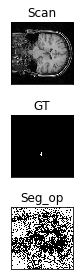

-------------- DONE --------------
---------- VALIDATING ------------


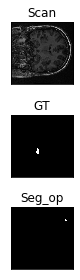

---------- EPOCH: 2 ----------
----------- TRAINING -------------


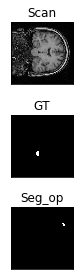

-------------- DONE --------------
---------- VALIDATING ------------


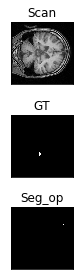

---------- EPOCH: 3 ----------
----------- TRAINING -------------


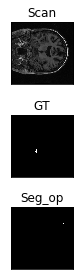

-------------- DONE --------------
---------- VALIDATING ------------


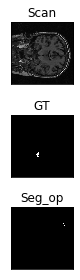

---------- EPOCH: 4 ----------
----------- TRAINING -------------


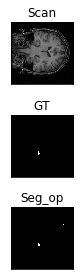

-------------- DONE --------------
---------- VALIDATING ------------


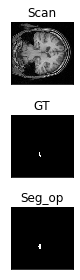

---------- EPOCH: 5 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


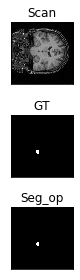

---------- EPOCH: 6 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


---------- EPOCH: 7 ----------
----------- TRAINING -------------


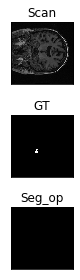

-------------- DONE --------------
---------- VALIDATING ------------


---------- EPOCH: 8 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


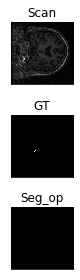

---------- EPOCH: 9 ----------
----------- TRAINING -------------


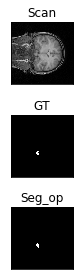

-------------- DONE --------------
---------- VALIDATING ------------


---------- EPOCH: 10 ----------
----------- TRAINING -------------


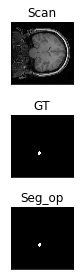

-------------- DONE --------------
---------- VALIDATING ------------


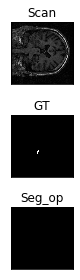

In [281]:
# with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
pbar_outer_outer = tqdm(total=epochs, desc = 'Epoch count')
pbar_outer = tqdm(total=epochs, desc = 'Epoch count')
for epoch in range(1, epochs+1):
    # print('Epoch: ', epoch)
    model0.train()
    avg_loss = 0.0
    avg_dscoeff = 0.0
    print('---------- EPOCH:', epoch, '----------')
    print('----------- TRAINING -------------')
    pbar_inner = tqdm(total = len(train_loader), desc = "train: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    dscoeffs = []
    for i, batch in enumerate(train_loader):
        count+=1
        optimizer.zero_grad()
#         print(len(batch[0]))
        input_img = Variable(batch[0][0].unsqueeze(0)).to(device)
        segs = Variable(batch[2][0].unsqueeze(0)).to(device)
        outputs = model0(input_img)
        # print(outputs.shape)
        # print(torch.argmax(outputs, 1).shape)
        
        loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
        loss.backward()
        optimizer.step()
        dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
        dscoeffs.append(dscoeff)
        
        
        if (count%1000==1):
            fig = plt.figure()
            plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,1).set_title('Scan')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,2).set_title('GT')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,3).set_title('Seg_op')
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            plt.show()
        # losses1.append(loss.item())
        # dscoeffs.append(dscoeff)
        avg_loss += loss.item()
        avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
        pbar_inner.set_description("train: Avg lnum_classesoss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/count,avg_dscoeff/count))
        pbar_inner.update(batch_size)
        pbar_outer.set_description("Epoch count: {}".format(epoch))
    # print(np.array(dscoeffs).shape)
    dscoeffs1.append(np.sum(np.array(dscoeffs), axis = 0)/len(train_loader))
    avg_losses1.append(avg_loss/len(train_loader))
    avg_dscoeffs1.append(avg_dscoeff/len(train_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/len(train_loader),avg_dscoeff/len(train_loader)))
#         pbar.set_postfix(**{'loss (batch)': loss.item(), 'DSC (batch)': dscoeff})
#         pbar.update(i)

    print('-------------- DONE --------------')
    # model0.eval()
    val_avg_loss = 0.0
    val_avg_dscoeff = 0.0
    print('---------- VALIDATING ------------')
    pbar_inner = tqdm(total = len(validation_loader), desc = "Val: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    val_dscoeffs = []
    for i, batch in enumerate(validation_loader):
        with torch.no_grad():
            count+=1
            # optimizer.zero_grad()
    #         print(len(batch[0]))
            input_img = Variable(batch[0][0].unsqueeze(0)).to(device)
            segs = Variable(batch[2][0].unsqueeze(0)).to(device)
            outputs = model0(input_img)
            # print(outputs.shape)
            # print(torch.unique(torch.argmax(outputs, 1)))
            
            loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
            # loss.backward()
            # optimizer.step()
            dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
            
            val_dscoeffs.append(dscoeff)
            
            # print(torch.unique(outs))
    #             print("Epoch:", epoch, "| Iter:", i+1, "| loss:", round(loss.item(), 4), "| dsc:", round(dscoeff, 4))
            if (count%1000==1):
                fig = plt.figure()
                plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,1).set_title('Scan')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,2).set_title('GT')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,3).set_title('Seg_op')
                plt.xticks([])
                plt.yticks([])
                plt.tight_layout()
                plt.show()
            # val_losses.append(loss.item())
            # val_dscoeffs.append(dscoeff)
            val_avg_loss += loss.item()
            val_avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
            pbar_inner.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/count,val_avg_dscoeff/count))
            pbar_inner.update(batch_size)
            pbar_outer.set_description("Epoch count: {}".format(epoch))
    val_dscoeffs1.append(np.sum(np.array(val_dscoeffs), axis=0)/len(validation_loader))
    val_avg_dscoeffs1.append(val_avg_dscoeff/len(validation_loader))
    val_avg_losses1.append(val_avg_loss/len(validation_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/len(validation_loader),val_avg_dscoeff/len(validation_loader)))

In [282]:
print(dscoeffs1[-1])
print(val_dscoeffs1[-1])

[0.99948391 0.52759884]
[0.99945437 0.48835447]


In [283]:
filepath = 'saved_model_NITRC_left_'+str(train_ratio)+'_SP.pt'
torch.save(model0.state_dict(), filepath)

In [284]:
# Right Class

epochs = 10
batch_size = 1
num_classes = 2
losses2 = []

dscoeffs2 = []
val_losses2 = []
val_dscoeffs2 = []
avg_losses2 = []
val_avg_losses2 = []
avg_dscoeffs2 = []
val_avg_dscoeffs2 = []

model1 = UNet2D(2, 1).to(device)
optimizer = optim.Adam(model1.parameters(), lr = 0.0001)

---------- EPOCH: 1 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


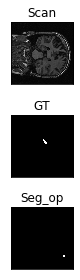

---------- EPOCH: 2 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


---------- EPOCH: 3 ----------
----------- TRAINING -------------


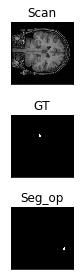

-------------- DONE --------------
---------- VALIDATING ------------


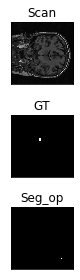

---------- EPOCH: 4 ----------
----------- TRAINING -------------


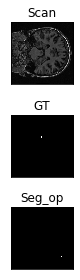

-------------- DONE --------------
---------- VALIDATING ------------


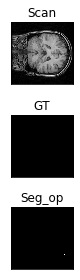

---------- EPOCH: 5 ----------
----------- TRAINING -------------


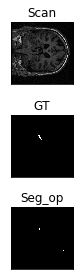

-------------- DONE --------------
---------- VALIDATING ------------


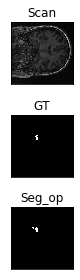

---------- EPOCH: 6 ----------
----------- TRAINING -------------


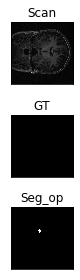

-------------- DONE --------------
---------- VALIDATING ------------


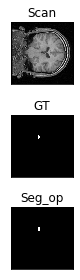

---------- EPOCH: 7 ----------
----------- TRAINING -------------


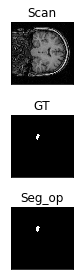

-------------- DONE --------------
---------- VALIDATING ------------


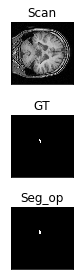

---------- EPOCH: 8 ----------
----------- TRAINING -------------


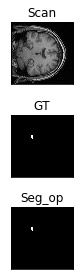

-------------- DONE --------------
---------- VALIDATING ------------


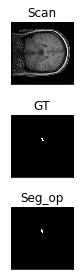

---------- EPOCH: 9 ----------
----------- TRAINING -------------


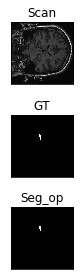

-------------- DONE --------------
---------- VALIDATING ------------


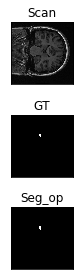

---------- EPOCH: 10 ----------
----------- TRAINING -------------


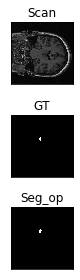

-------------- DONE --------------
---------- VALIDATING ------------


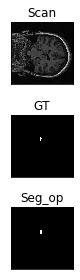

In [285]:
# with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
pbar_outer_outer = tqdm(total=epochs, desc = 'Epoch count')
pbar_outer = tqdm(total=epochs, desc = 'Epoch count')
for epoch in range(1, epochs+1):
    # print('Epoch: ', epoch)
    model1.train()
    avg_loss = 0.0
    avg_dscoeff = 0.0
    print('---------- EPOCH:', epoch, '----------')
    print('----------- TRAINING -------------')
    pbar_inner = tqdm(total = len(train_loader), desc = "train: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    dscoeffs = []
    for i, batch in enumerate(train_loader):
        count+=1
        optimizer.zero_grad()
#         print(len(batch[0]))
        input_img = Variable(batch[0][0].unsqueeze(0)).to(device)
        segs = Variable(batch[3][0].unsqueeze(0)).to(device)
        outputs = model1(input_img)
        # print(outputs.shape)
        # print(torch.argmax(outputs, 1).shape)
        
        loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
        loss.backward()
        optimizer.step()
        dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
        dscoeffs.append(dscoeff)
        
        
        if (count%1000==1):
            fig = plt.figure()
            plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,1).set_title('Scan')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,2).set_title('GT')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,3).set_title('Seg_op')
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            plt.show()
        # losses1.append(loss.item())
        # dscoeffs.append(dscoeff)
        avg_loss += loss.item()
        avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
        pbar_inner.set_description("train: Avg lnum_classesoss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/count,avg_dscoeff/count))
        pbar_inner.update(batch_size)
        pbar_outer.set_description("Epoch count: {}".format(epoch))
    # print(np.array(dscoeffs).shape)
    dscoeffs2.append(np.sum(np.array(dscoeffs), axis = 0)/len(train_loader))
    avg_losses2.append(avg_loss/len(train_loader))
    avg_dscoeffs2.append(avg_dscoeff/len(train_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/len(train_loader),avg_dscoeff/len(train_loader)))
#         pbar.set_postfix(**{'loss (batch)': loss.item(), 'DSC (batch)': dscoeff})
#         pbar.update(i)

    print('-------------- DONE --------------')
    val_avg_loss = 0.0
    val_avg_dscoeff = 0.0
    print('---------- VALIDATING ------------')
    pbar_inner = tqdm(total = len(validation_loader), desc = "Val: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    val_dscoeffs = []
    for i, batch in enumerate(validation_loader):
        with torch.no_grad():
            count+=1
            # optimizer.zero_grad()
    #         print(len(batch[0]))
            input_img = Variable(batch[0][0].unsqueeze(0)).to(device)
            segs = Variable(batch[3][0].unsqueeze(0)).to(device)
            outputs = model1(input_img)
            # print(outputs.shape)
            # print(torch.unique(torch.argmax(outputs, 1)))
            
            loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
            # loss.backward()
            # optimizer.step()
            dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
            
            val_dscoeffs.append(dscoeff)
            
            # print(torch.unique(outs))
    #             print("Epoch:", epoch, "| Iter:", i+1, "| loss:", round(loss.item(), 4), "| dsc:", round(dscoeff, 4))
            if (count%1000==1):
                fig = plt.figure()
                plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,1).set_title('Scan')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,2).set_title('GT')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,3).set_title('Seg_op')
                plt.xticks([])
                plt.yticks([])
                plt.tight_layout()
                plt.show()
            # val_losses.append(loss.item())
            # val_dscoeffs.append(dscoeff)
            val_avg_loss += loss.item()
            val_avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
            pbar_inner.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/count,val_avg_dscoeff/count))
            pbar_inner.update(batch_size)
            pbar_outer.set_description("Epoch count: {}".format(epoch))
    val_dscoeffs2.append(np.sum(np.array(val_dscoeffs), axis=0)/len(validation_loader))
    val_avg_dscoeffs2.append(val_avg_dscoeff/len(validation_loader))
    val_avg_losses2.append(val_avg_loss/len(validation_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/len(validation_loader),val_avg_dscoeff/len(validation_loader)))

In [286]:
print(dscoeffs2[-1])
print(val_dscoeffs2[-1])

[0.99973379 0.82420162]
[0.99967647 0.81796554]


In [287]:
filepath = 'saved_model_NITRC_right_'+str(train_ratio)+'_SP.pt'
torch.save(model1.state_dict(), filepath)

In [29]:
from torchvision import utils


In [30]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [288]:
train_ratio = 1

In [289]:
model1 = UNet2D(2, 1).to(device)
model1.load_state_dict(torch.load('saved_model_NITRC_left_'+str(train_ratio)+'_SP.pt', map_location=device))
model0 = UNet2D(2, 1).to(device)
model0.load_state_dict(torch.load('saved_model_NITRC_right_'+str(train_ratio)+'_SP.pt', map_location=device))

<All keys matched successfully>

In [290]:
params1 = model0.state_dict()
filter_list = []
for item in params1:
    # print(params1[item].type())
    if params1[item].type() == 'torch.cuda.FloatTensor':
        params1[item].requires_grad = True
    if (params1[item].requires_grad == True):
        # print(params1[item].requires_grad)
        filter_list.append(params1[item])

In [291]:
# filter_list

In [292]:
# params1 = model0.state_dict()
# filter_list = []
# for item in params1:
#     if (params1[item].requires_grad==True):
#         filter_list.append(params1[item])
# filter_list

In [293]:
# params2 = model1.state_dict()
# filter_list2 = []
# for item in params2:
#     if (len(params2[item].shape)>3):
#         filter_list2.append(params2[item])

In [294]:
params2 = model1.state_dict()
filter_list2 = []
for item in params2:
    # print(params1[item].type())
    if params2[item].type() == 'torch.cuda.FloatTensor':
        params2[item].requires_grad = True
    if (params2[item].requires_grad == True):
        # print(params1[item].requires_grad)
        filter_list2.append(params2[item])

In [295]:
print(len(filter_list), len(filter_list2))
diff_norm = []
for i in range(len(filter_list)):
    # print(filter_list[i].shape==filter_list2[i].shape)
    new_ten = filter_list[i] - filter_list2[i]
    print(torch.norm(new_ten))
    diff_norm.append(torch.norm(new_ten))

134 134
tensor(4.4493, device='cuda:0', grad_fn=<NormBackward0>)
tensor(1.6218, device='cuda:0', grad_fn=<NormBackward0>)
tensor(0.0846, device='cuda:0', grad_fn=<NormBackward0>)
tensor(0.0621, device='cuda:0', grad_fn=<NormBackward0>)
tensor(185.2039, device='cuda:0', grad_fn=<NormBackward0>)
tensor(4697.9531, device='cuda:0', grad_fn=<NormBackward0>)
tensor(4.6696, device='cuda:0', grad_fn=<NormBackward0>)
tensor(0.2466, device='cuda:0', grad_fn=<NormBackward0>)
tensor(0.0491, device='cuda:0', grad_fn=<NormBackward0>)
tensor(0.0826, device='cuda:0', grad_fn=<NormBackward0>)
tensor(3.3043, device='cuda:0', grad_fn=<NormBackward0>)
tensor(4.2134, device='cuda:0', grad_fn=<NormBackward0>)
tensor(6.5697, device='cuda:0', grad_fn=<NormBackward0>)
tensor(0.4270, device='cuda:0', grad_fn=<NormBackward0>)
tensor(0.0710, device='cuda:0', grad_fn=<NormBackward0>)
tensor(0.0691, device='cuda:0', grad_fn=<NormBackward0>)
tensor(4.2292, device='cuda:0', grad_fn=<NormBackward0>)
tensor(1.9998, dev

In [296]:
diff_norm[3].cpu().detach()>11
diff_sum=0
for i in range(len(diff_norm)):
    diff_sum += diff_norm[3].cpu().detach()
print(diff_sum/len(diff_norm)*20)

tensor(1.2420)


In [297]:
count = 0
for item in params1:
    if params1[item].type() == 'torch.cuda.FloatTensor':
        if diff_norm[count].cpu() > 15:
            params1[item].requires_grad = True
        else:
            params1[item].requires_grad = False
        count+=1
    print(item, params1[item].requires_grad)

encoder_block0.conv_block1.conv1.weight False
encoder_block0.conv_block1.conv1.bias False
encoder_block0.conv_block1.conv1_bn.weight False
encoder_block0.conv_block1.conv1_bn.bias False
encoder_block0.conv_block1.conv1_bn.running_mean True
encoder_block0.conv_block1.conv1_bn.running_var True
encoder_block0.conv_block1.conv1_bn.num_batches_tracked False
encoder_block0.conv_block1.conv2.weight False
encoder_block0.conv_block1.conv2.bias False
encoder_block0.conv_block1.conv2_bn.weight False
encoder_block0.conv_block1.conv2_bn.bias False
encoder_block0.conv_block1.conv2_bn.running_mean False
encoder_block0.conv_block1.conv2_bn.running_var False
encoder_block0.conv_block1.conv2_bn.num_batches_tracked False
encoder_block1.conv_block1.conv1.weight False
encoder_block1.conv_block1.conv1.bias False
encoder_block1.conv_block1.conv1_bn.weight False
encoder_block1.conv_block1.conv1_bn.bias False
encoder_block1.conv_block1.conv1_bn.running_mean False
encoder_block1.conv_block1.conv1_bn.running_var

In [298]:
model0.train()
for item in params1:
    print(item, params1[item].requires_grad)

encoder_block0.conv_block1.conv1.weight False
encoder_block0.conv_block1.conv1.bias False
encoder_block0.conv_block1.conv1_bn.weight False
encoder_block0.conv_block1.conv1_bn.bias False
encoder_block0.conv_block1.conv1_bn.running_mean True
encoder_block0.conv_block1.conv1_bn.running_var True
encoder_block0.conv_block1.conv1_bn.num_batches_tracked False
encoder_block0.conv_block1.conv2.weight False
encoder_block0.conv_block1.conv2.bias False
encoder_block0.conv_block1.conv2_bn.weight False
encoder_block0.conv_block1.conv2_bn.bias False
encoder_block0.conv_block1.conv2_bn.running_mean False
encoder_block0.conv_block1.conv2_bn.running_var False
encoder_block0.conv_block1.conv2_bn.num_batches_tracked False
encoder_block1.conv_block1.conv1.weight False
encoder_block1.conv_block1.conv1.bias False
encoder_block1.conv_block1.conv1_bn.weight False
encoder_block1.conv_block1.conv1_bn.bias False
encoder_block1.conv_block1.conv1_bn.running_mean False
encoder_block1.conv_block1.conv1_bn.running_var

In [299]:
model2 = UNet2D(3, 1).to(device)
params3 = model2.state_dict()

In [300]:
for item in params1:
    if item in params3:
        if (params3[item].shape == params1[item].shape):
            params3[item] = params1[item]
            params3[item].requires_grad = params1[item].requires_grad

In [301]:
model2.train()
for item in params3:
    print(item, params3[item].requires_grad)

encoder_block0.conv_block1.conv1.weight False
encoder_block0.conv_block1.conv1.bias False
encoder_block0.conv_block1.conv1_bn.weight False
encoder_block0.conv_block1.conv1_bn.bias False
encoder_block0.conv_block1.conv1_bn.running_mean True
encoder_block0.conv_block1.conv1_bn.running_var True
encoder_block0.conv_block1.conv1_bn.num_batches_tracked False
encoder_block0.conv_block1.conv2.weight False
encoder_block0.conv_block1.conv2.bias False
encoder_block0.conv_block1.conv2_bn.weight False
encoder_block0.conv_block1.conv2_bn.bias False
encoder_block0.conv_block1.conv2_bn.running_mean False
encoder_block0.conv_block1.conv2_bn.running_var False
encoder_block0.conv_block1.conv2_bn.num_batches_tracked False
encoder_block1.conv_block1.conv1.weight False
encoder_block1.conv_block1.conv1.bias False
encoder_block1.conv_block1.conv1_bn.weight False
encoder_block1.conv_block1.conv1_bn.bias False
encoder_block1.conv_block1.conv1_bn.running_mean False
encoder_block1.conv_block1.conv1_bn.running_var

In [302]:
pytorch_total_params = sum(params3[p].numel() for p in params3 if params3[p].requires_grad)
print(pytorch_total_params)

4066496


In [303]:
# root_dir = '../data/Task04_Hippocampus_processed'
# labeldir = 'labels_left'
# labeldir_2 = 'labelsTr'

# validation_split = 0.2
# shuffle_dataset = True
# random_seed= 42
# batch_size = 1
# train_ratio = 0.6

# dataset = MSD(root = root_dir, labeldir1 = labeldir, labeldir2 = labeldir_2, train_ratio = train_ratio)

# dataset_size = len(dataset)
# indices = list(range(dataset_size))
# split = int(np.floor(validation_split * dataset_size))
# if shuffle_dataset :
#     np.random.seed(random_seed)
#     np.random.shuffle(indices)
# train_indices, val_indices = indices[split:], indices[:split]
# # print(train_indices, val_indices)

In [304]:

# train_sampler = SubsetRandomSampler(train_indices[0:int(train_ratio*len(train_indices))])
# valid_sampler = SubsetRandomSampler(val_indices)

# train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
#                                            sampler=train_sampler)
# validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
#                                                 sampler=valid_sampler)


# # dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
# n_train = len(train_loader)
# n_val = len(validation_loader)
# a = iter(train_loader)
# batch = a.next()
# print(len(batch), n_train, n_val)

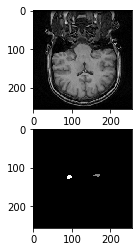

In [305]:
# print(np.unique(dataset[10][2]))
fig = plt.figure()
plt.subplot(2,1,1).imshow(dataset[10][0][0].squeeze().numpy().T, cmap='gray')
plt.subplot(2,1,2).imshow(dataset[10][1].squeeze().numpy().T, cmap='gray')
plt.show()

In [306]:
# Left Class

epochs = 20
batch_size = 1
num_classes = 3
losses3 = []

dscoeffs3 = []
val_losses3 = []
val_dscoeffs3 = []
avg_losses3 = []
val_avg_losses3 = []
avg_dscoeffs3 = []
val_avg_dscoeffs3 = []

optimizer = optim.Adam(model2.parameters(), lr = 0.0001)

---------- EPOCH: 1 ----------
----------- TRAINING -------------


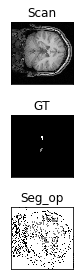

-------------- DONE --------------
---------- VALIDATING ------------


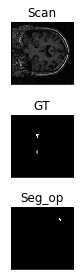

---------- EPOCH: 2 ----------
----------- TRAINING -------------


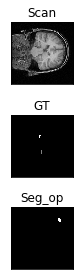

-------------- DONE --------------
---------- VALIDATING ------------


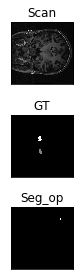

---------- EPOCH: 3 ----------
----------- TRAINING -------------


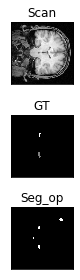

-------------- DONE --------------
---------- VALIDATING ------------


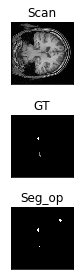

---------- EPOCH: 4 ----------
----------- TRAINING -------------


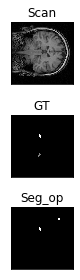

-------------- DONE --------------
---------- VALIDATING ------------


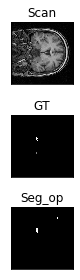

---------- EPOCH: 5 ----------
----------- TRAINING -------------


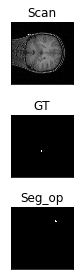

-------------- DONE --------------
---------- VALIDATING ------------


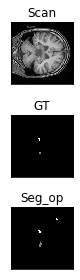

---------- EPOCH: 6 ----------
----------- TRAINING -------------


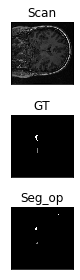

-------------- DONE --------------
---------- VALIDATING ------------


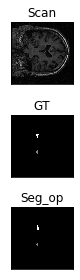

---------- EPOCH: 7 ----------
----------- TRAINING -------------


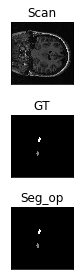

-------------- DONE --------------
---------- VALIDATING ------------


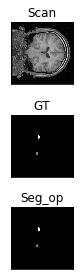



---------- EPOCH: 8 ----------
----------- TRAINING -------------


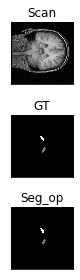

-------------- DONE --------------
---------- VALIDATING ------------


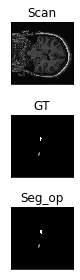

---------- EPOCH: 9 ----------
----------- TRAINING -------------


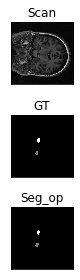

-------------- DONE --------------
---------- VALIDATING ------------


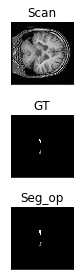

---------- EPOCH: 10 ----------
----------- TRAINING -------------


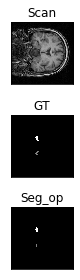

-------------- DONE --------------
---------- VALIDATING ------------


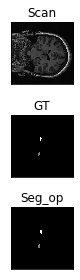

---------- EPOCH: 11 ----------
----------- TRAINING -------------


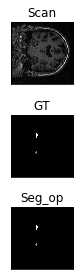

-------------- DONE --------------
---------- VALIDATING ------------


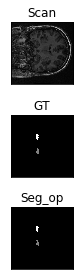

---------- EPOCH: 12 ----------
----------- TRAINING -------------


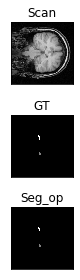

-------------- DONE --------------
---------- VALIDATING ------------


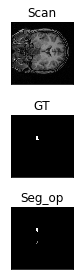

---------- EPOCH: 13 ----------
----------- TRAINING -------------


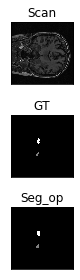

-------------- DONE --------------
---------- VALIDATING ------------


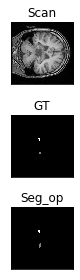

---------- EPOCH: 14 ----------
----------- TRAINING -------------


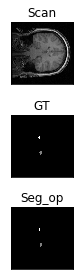

-------------- DONE --------------
---------- VALIDATING ------------


---------- EPOCH: 15 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


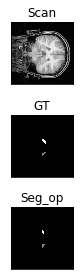

---------- EPOCH: 16 ----------
----------- TRAINING -------------


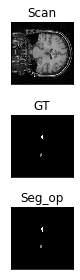

-------------- DONE --------------
---------- VALIDATING ------------


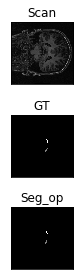

---------- EPOCH: 17 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


---------- EPOCH: 18 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


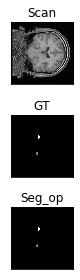

---------- EPOCH: 19 ----------
----------- TRAINING -------------


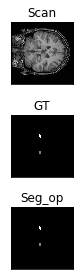

-------------- DONE --------------
---------- VALIDATING ------------


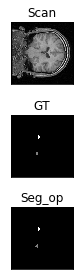

---------- EPOCH: 20 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


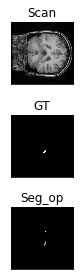

In [307]:
# with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
pbar_outer_outer = tqdm(total=epochs, desc = 'Epoch count')
pbar_outer = tqdm(total=epochs, desc = 'Epoch count')
for epoch in range(1, epochs+1):
    # print('Epoch: ', epoch)
    model2.train()
    avg_loss = 0.0
    avg_dscoeff = 0.0
    print('---------- EPOCH:', epoch, '----------')
    print('----------- TRAINING -------------')
    pbar_inner = tqdm(total = len(train_loader), desc = "train: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    dscoeffs = []
    for i, batch in enumerate(train_loader):
        count+=1
        optimizer.zero_grad()
#         print(len(batch[0]))
        input_img = Variable(batch[0][0].unsqueeze(0)).to(device)
        segs = Variable(batch[1][0].unsqueeze(0)).to(device)
        outputs = model2(input_img)
        # print(outputs.shape)
        # print(torch.argmax(outputs, 1).shape)
        
        loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
        loss.backward()
        optimizer.step()
        dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
        dscoeffs.append(dscoeff)
        
        
        if (count%1000==1):
            fig = plt.figure()
            plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,1).set_title('Scan')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,2).set_title('GT')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,3).set_title('Seg_op')
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            plt.show()
        # losses1.append(loss.item())
        # dscoeffs.append(dscoeff)
        avg_loss += loss.item()
        avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
        pbar_inner.set_description("train: Avg lnum_classesoss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/count,avg_dscoeff/count))
        pbar_inner.update(batch_size)
        pbar_outer.set_description("Epoch count: {}".format(epoch))
    # print(np.array(dscoeffs).shape)
    dscoeffs3.append(np.sum(np.array(dscoeffs), axis = 0)/len(train_loader))
    avg_losses3.append(avg_loss/len(train_loader))
    avg_dscoeffs3.append(avg_dscoeff/len(train_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/len(train_loader),avg_dscoeff/len(train_loader)))
#         pbar.set_postfix(**{'loss (batch)': loss.item(), 'DSC (batch)': dscoeff})
#         pbar.update(i)

    print('-------------- DONE --------------')
    val_avg_loss = 0.0
    val_avg_dscoeff = 0.0
    print('---------- VALIDATING ------------')
    pbar_inner = tqdm(total = len(validation_loader), desc = "Val: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    val_dscoeffs = []
    for i, batch in enumerate(validation_loader):
        with torch.no_grad():
            count+=1
            # optimizer.zero_grad()
    #         print(len(batch[0]))
            input_img = Variable(batch[0][0].unsqueeze(0)).to(device)
            segs = Variable(batch[1][0].unsqueeze(0)).to(device)
            outputs = model2(input_img)
            # print(outputs.shape)
            # print(torch.unique(torch.argmax(outputs, 1)))
            
            loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
            # loss.backward()
            # optimizer.step()
            dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
            
            val_dscoeffs.append(dscoeff)
            
            # print(torch.unique(outs))
    #             print("Epoch:", epoch, "| Iter:", i+1, "| loss:", round(loss.item(), 4), "| dsc:", round(dscoeff, 4))
            if (count%1000==1):
                fig = plt.figure()
                plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,1).set_title('Scan')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,2).set_title('GT')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,3).set_title('Seg_op')
                plt.xticks([])
                plt.yticks([])
                plt.tight_layout()
                plt.show()
            # val_losses.append(loss.item())
            # val_dscoeffs.append(dscoeff)
            val_avg_loss += loss.item()
            val_avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
            pbar_inner.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/count,val_avg_dscoeff/count))
            pbar_inner.update(batch_size)
            pbar_outer.set_description("Epoch count: {}".format(epoch))
    val_dscoeffs3.append(np.sum(np.array(val_dscoeffs), axis=0)/len(validation_loader))
    val_avg_dscoeffs3.append(val_avg_dscoeff/len(validation_loader))
    val_avg_losses3.append(val_avg_loss/len(validation_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/len(validation_loader),val_avg_dscoeff/len(validation_loader)))
    filepath = 'NITRC_models/saved_model_NITRC_UNetNFT_'+str(epoch)+'_'+str(train_ratio)+'_SP.pt'
    torch.save(model2.state_dict(), filepath)

In [308]:
print(dscoeffs3[-1])
print(val_dscoeffs3[-1])

[0.99967693 0.88633681 0.88231322]
[0.99945027 0.82618158 0.80600011]


In [309]:
print(dscoeffs3[-1])
print(val_dscoeffs3)

[0.99967693 0.88633681 0.88231322]
[array([0.99729486, 0.01020473, 0.0029013 ]), array([0.99790758, 0.01139908, 0.13713134]), array([0.99838276, 0.02545716, 0.51150174]), array([0.99850585, 0.03363706, 0.63881197]), array([0.99900068, 0.72575247, 0.66085777]), array([0.99921497, 0.72291533, 0.73433716]), array([0.99908337, 0.74335634, 0.71090998]), array([0.9993507 , 0.79751897, 0.76119958]), array([0.99936392, 0.75939746, 0.76637332]), array([0.99935852, 0.76630013, 0.76679969]), array([0.99940731, 0.81583121, 0.76463891]), array([0.999437  , 0.76562495, 0.80536771]), array([0.99944361, 0.79714126, 0.7864355 ]), array([0.99944683, 0.81151086, 0.80400772]), array([0.9994338 , 0.78879239, 0.79352454]), array([0.99945394, 0.78753731, 0.80401481]), array([0.99942308, 0.78202429, 0.79315777]), array([0.99946964, 0.82175196, 0.8087575 ]), array([0.99944166, 0.8163863 , 0.78978649]), array([0.99945027, 0.82618158, 0.80600011])]


In [310]:
final_avg = np.array(val_avg_dscoeffs3)
max_epoch = np.where(final_avg==np.max(final_avg))
max_epoch

(array([19]),)

In [311]:
print(val_dscoeffs3[max_epoch[0][0]])
print(final_avg[max_epoch[0][0]])

[0.99945027 0.82618158 0.80600011]
0.8772106534835916


In [312]:
# filepath_new = 'NITRC_models/best_model/saved_model_NITRC_UNetNFT_'+str(max_epoch+1)+'_'+str(train_ratio)+'_SP.pt'
# torch.save(model2.state_dict(), filepath)

In [313]:
# UNet

epochs = 30
batch_size = 1
num_classes = 3
losses1 = []

dscoeffs4 = []
val_losses4 = []
val_dscoeffs4 = []
avg_losses4 = []
val_avg_losses4 = []
avg_dscoeffs4 = []
val_avg_dscoeffs4 = []

model3 = UNet2D(3, 1).to(device)
optimizer = optim.Adam(model3.parameters(), lr = 0.0001)

In [314]:
params4 = model3.state_dict()
for item in params4:
    # print(params1[item].type())
    if params4[item].type() == 'torch.cuda.FloatTensor':
        params4[item].requires_grad = True
    if (params4[item].requires_grad == True):
        print(item, params4[item].requires_grad)
        # filter_list2.append(params2[item])

encoder_block0.conv_block1.conv1.weight True
encoder_block0.conv_block1.conv1.bias True
encoder_block0.conv_block1.conv1_bn.weight True
encoder_block0.conv_block1.conv1_bn.bias True
encoder_block0.conv_block1.conv1_bn.running_mean True
encoder_block0.conv_block1.conv1_bn.running_var True
encoder_block0.conv_block1.conv2.weight True
encoder_block0.conv_block1.conv2.bias True
encoder_block0.conv_block1.conv2_bn.weight True
encoder_block0.conv_block1.conv2_bn.bias True
encoder_block0.conv_block1.conv2_bn.running_mean True
encoder_block0.conv_block1.conv2_bn.running_var True
encoder_block1.conv_block1.conv1.weight True
encoder_block1.conv_block1.conv1.bias True
encoder_block1.conv_block1.conv1_bn.weight True
encoder_block1.conv_block1.conv1_bn.bias True
encoder_block1.conv_block1.conv1_bn.running_mean True
encoder_block1.conv_block1.conv1_bn.running_var True
encoder_block1.conv_block1.conv2.weight True
encoder_block1.conv_block1.conv2.bias True
encoder_block1.conv_block1.conv2_bn.weight Tr

In [315]:
pytorch_total_params = sum(p.numel() for p in model3.parameters() if p.requires_grad)
print(pytorch_total_params)

7767395


---------- EPOCH: 1 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


---------- EPOCH: 2 ----------
----------- TRAINING -------------


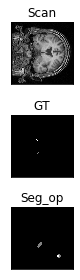

-------------- DONE --------------
---------- VALIDATING ------------


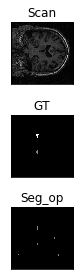

---------- EPOCH: 3 ----------
----------- TRAINING -------------


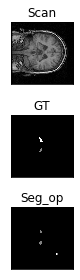

-------------- DONE --------------
---------- VALIDATING ------------


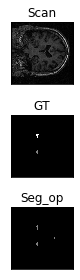

---------- EPOCH: 4 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


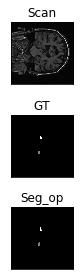

---------- EPOCH: 5 ----------
----------- TRAINING -------------


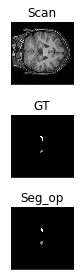

-------------- DONE --------------
---------- VALIDATING ------------


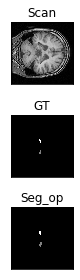

---------- EPOCH: 6 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


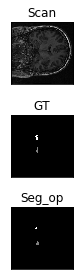

---------- EPOCH: 7 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


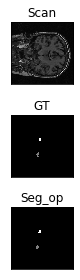

---------- EPOCH: 8 ----------
----------- TRAINING -------------


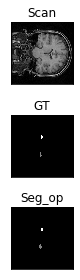

-------------- DONE --------------
---------- VALIDATING ------------


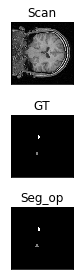

---------- EPOCH: 9 ----------
----------- TRAINING -------------


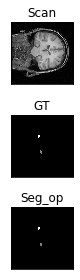

-------------- DONE --------------
---------- VALIDATING ------------


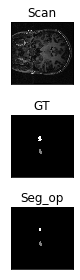

---------- EPOCH: 10 ----------
----------- TRAINING -------------


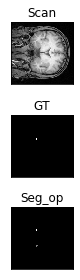

-------------- DONE --------------
---------- VALIDATING ------------


---------- EPOCH: 11 ----------
----------- TRAINING -------------


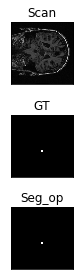

-------------- DONE --------------
---------- VALIDATING ------------


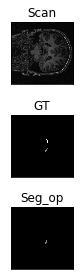

---------- EPOCH: 12 ----------
----------- TRAINING -------------


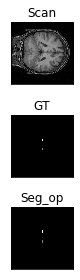

-------------- DONE --------------
---------- VALIDATING ------------


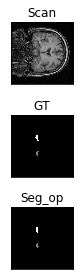

---------- EPOCH: 13 ----------
----------- TRAINING -------------


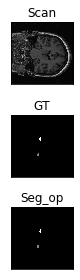

-------------- DONE --------------
---------- VALIDATING ------------


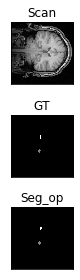

---------- EPOCH: 14 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


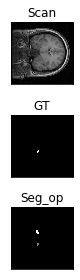

---------- EPOCH: 15 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


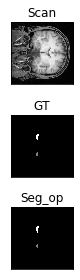

---------- EPOCH: 16 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


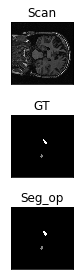

---------- EPOCH: 17 ----------
----------- TRAINING -------------


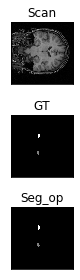

-------------- DONE --------------
---------- VALIDATING ------------


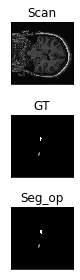

---------- EPOCH: 18 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


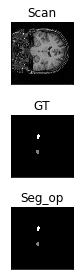

---------- EPOCH: 19 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


---------- EPOCH: 20 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


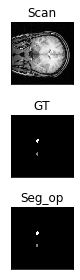

---------- EPOCH: 21 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


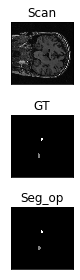

---------- EPOCH: 22 ----------
----------- TRAINING -------------


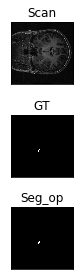

-------------- DONE --------------
---------- VALIDATING ------------


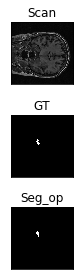

---------- EPOCH: 23 ----------
----------- TRAINING -------------


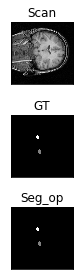

-------------- DONE --------------
---------- VALIDATING ------------


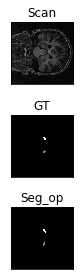

---------- EPOCH: 24 ----------
----------- TRAINING -------------


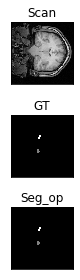

-------------- DONE --------------
---------- VALIDATING ------------


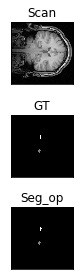

---------- EPOCH: 25 ----------
----------- TRAINING -------------


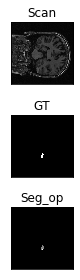

-------------- DONE --------------
---------- VALIDATING ------------


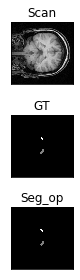

---------- EPOCH: 26 ----------
----------- TRAINING -------------


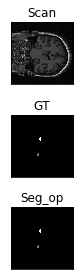

-------------- DONE --------------
---------- VALIDATING ------------


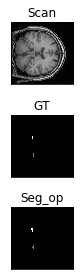

---------- EPOCH: 27 ----------
----------- TRAINING -------------


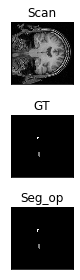

-------------- DONE --------------
---------- VALIDATING ------------


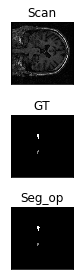

---------- EPOCH: 28 ----------
----------- TRAINING -------------


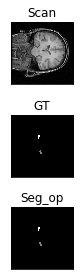

-------------- DONE --------------
---------- VALIDATING ------------


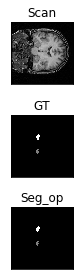

---------- EPOCH: 29 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


---------- EPOCH: 30 ----------
----------- TRAINING -------------


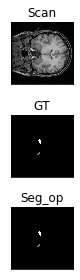

-------------- DONE --------------
---------- VALIDATING ------------


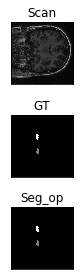

In [316]:
# with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
pbar_outer_outer = tqdm(total=epochs, desc = 'Epoch count')
pbar_outer = tqdm(total=epochs, desc = 'Epoch count')
for epoch in range(1, epochs+1):
    # print('Epoch: ', epoch)
    model3.train()
    avg_loss = 0.0
    avg_dscoeff = 0.0
    print('---------- EPOCH:', epoch, '----------')
    print('----------- TRAINING -------------')
    pbar_inner = tqdm(total = len(train_loader), desc = "train: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    dscoeffs = []
    for i, batch in enumerate(train_loader):
        count+=1
        optimizer.zero_grad()
#         print(len(batch[0]))
        input_img = Variable(batch[0][0].unsqueeze(0).type(torch.FloatTensor)).to(device)
        segs = Variable(batch[1][0].unsqueeze(0).type(torch.LongTensor)).to(device)
        outputs = model3(input_img)
        # print(torch.argmax(outputs, 1).shape)
        
        loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
        loss.backward()
        optimizer.step()
        dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
        dscoeffs.append(dscoeff)
        
        
        if (count%1000==1):
            fig = plt.figure()
            plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,1).set_title('Scan')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,2).set_title('GT')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,3).set_title('Seg_op')
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            plt.show()
        # losses1.append(loss.item())
        # dscoeffs.append(dscoeff)
        avg_loss += loss.item()
        avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
        pbar_inner.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/count,avg_dscoeff/count))
        pbar_inner.update(batch_size)
        pbar_outer.set_description("Epoch count: {}".format(epoch))
    # print(np.array(dscoeffs).shape)
    dscoeffs4.append(np.sum(np.array(dscoeffs), axis = 0)/len(train_loader))
    avg_losses4.append(avg_loss/len(train_loader))
    avg_dscoeffs4.append(avg_dscoeff/len(train_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/len(train_loader),avg_dscoeff/len(train_loader)))
#         pbar.set_postfix(**{'loss (batch)': loss.item(), 'DSC (batch)': dscoeff})
#         pbar.update(i)

    print('-------------- DONE --------------')
    # model0.eval()
    val_avg_loss = 0.0
    val_avg_dscoeff = 0.0
    print('---------- VALIDATING ------------')
    pbar_inner = tqdm(total = len(validation_loader), desc = "Val: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    val_dscoeffs = []
    for i, batch in enumerate(validation_loader):
        with torch.no_grad():
            count+=1
            # optimizer.zero_grad()
    #         print(len(batch[0]))
            input_img = Variable(batch[0][0].unsqueeze(0).type(torch.FloatTensor)).to(device)
            segs = Variable(batch[1][0].unsqueeze(0).type(torch.LongTensor)).to(device)
            outputs = model3(input_img)
            # print(outputs.shape)
            # print(torch.unique(torch.argmax(outputs, 1)))
            
            loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
            # loss.backward()
            # optimizer.step()
            dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
            
            val_dscoeffs.append(dscoeff)
            
            # print(torch.unique(outs))
    #             print("Epoch:", epoch, "| Iter:", i+1, "| loss:", round(loss.item(), 4), "| dsc:", round(dscoeff, 4))
            if (count%1000==1):
                fig = plt.figure()
                plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,1).set_title('Scan')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,2).set_title('GT')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,3).set_title('Seg_op')
                plt.xticks([])
                plt.yticks([])
                plt.tight_layout()
                plt.show()
            # val_losses.append(loss.item())
            # val_dscoeffs.append(dscoeff)
            val_avg_loss += loss.item()
            val_avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
            pbar_inner.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/count,val_avg_dscoeff/count))
            pbar_inner.update(batch_size)
            pbar_outer.set_description("Epoch count: {}".format(epoch))
    val_dscoeffs4.append(np.sum(np.array(val_dscoeffs), axis=0)/len(validation_loader))
    val_avg_dscoeffs4.append(val_avg_dscoeff/len(validation_loader))
    val_avg_losses4.append(val_avg_loss/len(validation_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/len(validation_loader),val_avg_dscoeff/len(validation_loader)))
    filepath = 'NITRC_models/saved_model_NITRC__UNet_'+str(epoch)+'_'+str(train_ratio)+'_SP.pt'
    torch.save(model2.state_dict(), filepath)

In [317]:
print(dscoeffs4[-1])
print(val_dscoeffs4[-1])

[0.99981297 0.93413919 0.94155203]
[0.99952675 0.84521155 0.80950085]


In [318]:
final_avg = np.array(val_avg_dscoeffs4)
max_epoch = np.where(final_avg==np.max(final_avg))
max_epoch

(array([18]),)

In [319]:
print(val_dscoeffs4[max_epoch[0][0]])
print(final_avg[max_epoch[0][0]])

[0.9995194  0.85360226 0.83090132]
0.8946743261896903


In [320]:
# filepath = 'saved_model_NITRC__UNet'+str(train_ratio)+'_SP.pt'
# torch.save(model3.state_dict(), filepath)

In [321]:
# MOUNet

In [322]:
# PHASE 1

epochs = 10
batch_size = 1
num_classes = 2
losses1 = []

dscoeffs5 = []
val_losses5 = []
val_dscoeffs5 = []
avg_losses5 = []
val_avg_losses5 = []
avg_dscoeffs5 = []
val_avg_dscoeffs5 = []

model4 = UNet2D(2, 1).to(device)
optimizer = optim.Adam(model4.parameters(), lr = 0.0001)

---------- EPOCH: 1 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


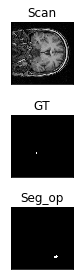

---------- EPOCH: 2 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


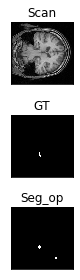

---------- EPOCH: 3 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


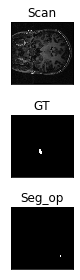

---------- EPOCH: 4 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


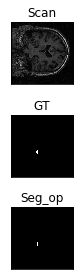

---------- EPOCH: 5 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


---------- EPOCH: 6 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


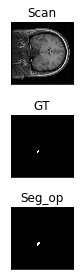

---------- EPOCH: 7 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


---------- EPOCH: 8 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


---------- EPOCH: 9 ----------
----------- TRAINING -------------


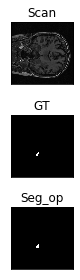

-------------- DONE --------------
---------- VALIDATING ------------


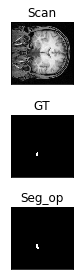

---------- EPOCH: 10 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


In [323]:
# with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
pbar_outer_outer = tqdm(total=epochs, desc = 'Epoch count')
pbar_outer = tqdm(total=epochs, desc = 'Epoch count')
for epoch in range(1, epochs+1):
    # print('Epoch: ', epoch)
    model4.train()
    avg_loss = 0.0
    avg_dscoeff = 0.0
    print('---------- EPOCH:', epoch, '----------')
    print('----------- TRAINING -------------')
    pbar_inner = tqdm(total = len(train_loader), desc = "train: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    dscoeffs = []
    for i, batch in enumerate(train_loader):
        count+=1
        optimizer.zero_grad()
#         print(len(batch[0]))
        input_img = Variable(batch[0][0].unsqueeze(0).type(torch.FloatTensor)).to(device)
        segs = Variable(batch[2][0].unsqueeze(0).type(torch.LongTensor)).to(device)
        outputs = model4(input_img)
        # print(torch.argmax(outputs, 1).shape)
        
        loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
        loss.backward()
        optimizer.step()
        dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
        dscoeffs.append(dscoeff)
        
        
        if (count%1000==1):
            fig = plt.figure()
            plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,1).set_title('Scan')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,2).set_title('GT')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,3).set_title('Seg_op')
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            plt.show()
        # losses1.append(loss.item())
        # dscoeffs.append(dscoeff)
        avg_loss += loss.item()
        avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
        pbar_inner.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/count,avg_dscoeff/count))
        pbar_inner.update(batch_size)
        pbar_outer.set_description("Epoch count: {}".format(epoch))
    # print(np.array(dscoeffs).shape)
    dscoeffs5.append(np.sum(np.array(dscoeffs), axis = 0)/len(train_loader))
    avg_losses5.append(avg_loss/len(train_loader))
    avg_dscoeffs5.append(avg_dscoeff/len(train_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/len(train_loader),avg_dscoeff/len(train_loader)))
#         pbar.set_postfix(**{'loss (batch)': loss.item(), 'DSC (batch)': dscoeff})
#         pbar.update(i)

    print('-------------- DONE --------------')
    # model0.eval()
    val_avg_loss = 0.0
    val_avg_dscoeff = 0.0
    print('---------- VALIDATING ------------')
    pbar_inner = tqdm(total = len(validation_loader), desc = "Val: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    val_dscoeffs = []
    for i, batch in enumerate(validation_loader):
        with torch.no_grad():
            count+=1
            # optimizer.zero_grad()
    #         print(len(batch[0]))
            input_img = Variable(batch[0][0].unsqueeze(0).type(torch.FloatTensor)).to(device)
            segs = Variable(batch[2][0].unsqueeze(0).type(torch.LongTensor)).to(device)
            outputs = model4(input_img)
            # print(outputs.shape)
            # print(torch.unique(torch.argmax(outputs, 1)))
            
            loss = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs)
            # loss.backward()
            # optimizer.step()
            dscoeff, outs, segs = dice_coeff_multiclass(segs, outputs, num_classes)
            
            val_dscoeffs.append(dscoeff)
            
            # print(torch.unique(outs))
    #             print("Epoch:", epoch, "| Iter:", i+1, "| loss:", round(loss.item(), 4), "| dsc:", round(dscoeff, 4))
            if (count%1000==1):
                fig = plt.figure()
                plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,1).set_title('Scan')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,2).set_title('GT')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,3).set_title('Seg_op')
                plt.xticks([])
                plt.yticks([])
                plt.tight_layout()
                plt.show()
            # val_losses.append(loss.item())
            # val_dscoeffs.append(dscoeff)
            val_avg_loss += loss.item()
            val_avg_dscoeff += sum(dscoeff)/(batch_size*num_classes)
            pbar_inner.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/count,val_avg_dscoeff/count))
            pbar_inner.update(batch_size)
            pbar_outer.set_description("Epoch count: {}".format(epoch))
    val_dscoeffs5.append(np.sum(np.array(val_dscoeffs), axis=0)/len(validation_loader))
    val_avg_dscoeffs5.append(val_avg_dscoeff/len(validation_loader))
    val_avg_losses5.append(val_avg_loss/len(validation_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/len(validation_loader),val_avg_dscoeff/len(validation_loader)))

In [324]:
print(dscoeffs5[-1])
print(val_dscoeffs5[-1])

[0.99971058 0.80427099]
[0.99968519 0.7913813 ]


In [325]:
filepath = 'NITRC_models/saved_model_NITRC_MO_left'+str(train_ratio)+'_SP.pt'
torch.save(model4.state_dict(), filepath)

In [326]:
model4 = UNet2D(2, 1).to(device)
model4.load_state_dict(torch.load(filepath, map_location=device))

<All keys matched successfully>

In [327]:
epochs = 20
batch_size = 1
Lambda = 0.8
num_channels = 1
num_classes_1 = 2
num_classes_2 = 3

losses6 = []
dscoeffs6 = []
val_dscoeffs6 = []
avg_losses6 = []
val_avg_losses6 = []
avg_dscoeffs6 = []
val_avg_dscoeffs6 = []

model_enc = MO_Net_encoder(num_channels).to(device)
model_dec1 = MO_Net_decoder(num_classes_1).to(device)
model_dec2 = MO_Net_decoder(num_classes_2).to(device)
params1 = model4.state_dict()
params2 = model_enc.state_dict()
params3 = model_dec1.state_dict()
params4 = model_dec2.state_dict()

In [328]:
# PHASE 2
for item in params1:
    if item in params2:
        params2[item] = params1[item]
for item in params1:
    if item in params3:
        params3[item] = params1[item]
for item in params1:
    if item in params4:
        if (params4[item].shape == params1[item].shape):
            params4[item] = params1[item]
model_enc.load_state_dict(params2)
model_dec1.load_state_dict(params3)
model_dec2.load_state_dict(params4)
optimizer0 = optim.Adam(model_enc.parameters(), lr = 0.000003)
optimizer1 = optim.Adam(model_dec1.parameters(), lr = 0.000001)
optimizer2 = optim.Adam(model_dec2.parameters(), lr = 0.00001)

---------- EPOCH: 1 ----------
----------- TRAINING -------------


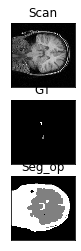

-------------- DONE --------------
---------- VALIDATING ------------


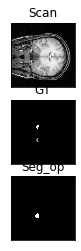

---------- EPOCH: 2 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


---------- EPOCH: 3 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


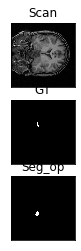

---------- EPOCH: 4 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


---------- EPOCH: 5 ----------
----------- TRAINING -------------


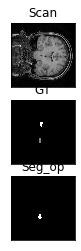

-------------- DONE --------------
---------- VALIDATING ------------


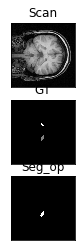

---------- EPOCH: 6 ----------
----------- TRAINING -------------


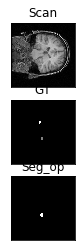

-------------- DONE --------------
---------- VALIDATING ------------


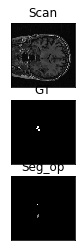

---------- EPOCH: 7 ----------
----------- TRAINING -------------


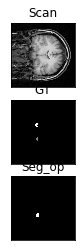

-------------- DONE --------------
---------- VALIDATING ------------


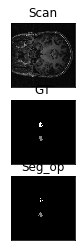

---------- EPOCH: 8 ----------
----------- TRAINING -------------


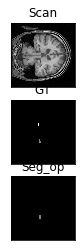

-------------- DONE --------------
---------- VALIDATING ------------


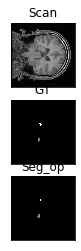

---------- EPOCH: 9 ----------
----------- TRAINING -------------


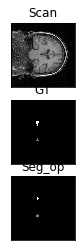

-------------- DONE --------------
---------- VALIDATING ------------


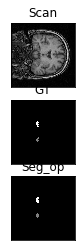

---------- EPOCH: 10 ----------
----------- TRAINING -------------


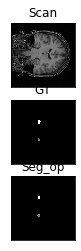

-------------- DONE --------------
---------- VALIDATING ------------


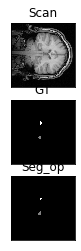

---------- EPOCH: 11 ----------
----------- TRAINING -------------


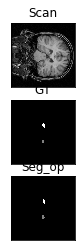

-------------- DONE --------------
---------- VALIDATING ------------


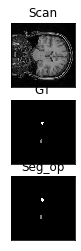

---------- EPOCH: 12 ----------
----------- TRAINING -------------


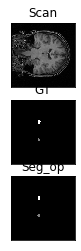

-------------- DONE --------------
---------- VALIDATING ------------


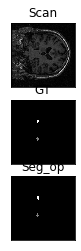

---------- EPOCH: 13 ----------
----------- TRAINING -------------


-------------- DONE --------------
---------- VALIDATING ------------


---------- EPOCH: 14 ----------
----------- TRAINING -------------


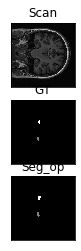

-------------- DONE --------------
---------- VALIDATING ------------


---------- EPOCH: 15 ----------
----------- TRAINING -------------


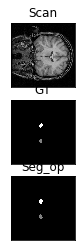

-------------- DONE --------------
---------- VALIDATING ------------


---------- EPOCH: 16 ----------
----------- TRAINING -------------


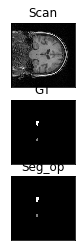

-------------- DONE --------------
---------- VALIDATING ------------


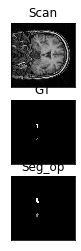

---------- EPOCH: 17 ----------
----------- TRAINING -------------


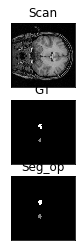

-------------- DONE --------------
---------- VALIDATING ------------


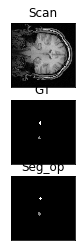

---------- EPOCH: 18 ----------
----------- TRAINING -------------


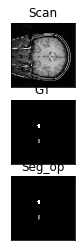

-------------- DONE --------------
---------- VALIDATING ------------


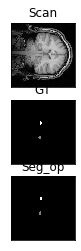

---------- EPOCH: 19 ----------
----------- TRAINING -------------


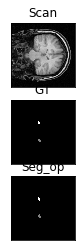

-------------- DONE --------------
---------- VALIDATING ------------


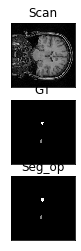

---------- EPOCH: 20 ----------
----------- TRAINING -------------


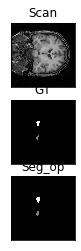

-------------- DONE --------------
---------- VALIDATING ------------


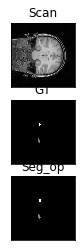

In [329]:
# with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
pbar_outer_outer = tqdm(total=epochs, desc = 'Epoch count')
pbar_outer = tqdm(total=epochs, desc = 'Epoch count')
for epoch in range(1, epochs+1):
    # print('Epoch: ', epoch)
    model_enc.train()
    model_dec1.train()
    model_dec2.train()
    avg_loss = 0.0
    avg_dscoeff = 0.0
    print('---------- EPOCH:', epoch, '----------')
    print('----------- TRAINING -------------')
    pbar_inner = tqdm(total = len(train_loader), desc = "train: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    dscoeffs = []
    for i, batch in enumerate(train_loader):
        count+=1
        optimizer0.zero_grad()
        optimizer1.zero_grad()
        optimizer2.zero_grad()
#         print(len(batch[0]))
        input_img = Variable(batch[0][0].unsqueeze(0).type(torch.FloatTensor)).to(device)
        segs = Variable(batch[2][0].unsqueeze(0).type(torch.LongTensor)).to(device)
        segs2 = Variable(batch[1][0].unsqueeze(0).type(torch.LongTensor)).to(device)
        encoder0, encoder1, encoder2, encoder3, center = model_enc(input_img)
        outputs1 = model_dec1(encoder0, encoder1, encoder2, encoder3, center)
        outputs2 = model_dec2(encoder0, encoder1, encoder2, encoder3, center)
        # print(torch.argmax(outputs, 1).shape)
        
        loss1 = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs1)
        loss2 = cross_ent_dice_loss(torch.squeeze(segs2, dim=1), outputs2)
        loss = ((1 - Lambda) * loss1) + (Lambda * loss2)
        loss.backward()

        optimizer0.step()
        optimizer1.step()
        optimizer2.step()

        dscoeff, outs, segs = dice_coeff_multiclass(segs2, outputs2, num_classes_2)
        dscoeffs.append(dscoeff)
#             print("Epoch:", epoch, "| Iter:", i+1, "| loss:", round(loss.item(), 4), "| dsc:", round(dscoeff, 4))
        if (count%1000==1):
            fig = plt.figure()
            plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,1).set_title('Scan')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,2).set_title('GT')
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(3,1,3).set_title('Seg_op')
            plt.xticks([])
            plt.yticks([])
            plt.show()

        # losses.append(loss.item())
        # dscoeffs.append(dscoeff)
        avg_loss += loss.item()/batch_size
        avg_dscoeff += sum(dscoeff)/(batch_size*num_classes_2)
        pbar_inner.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/count,avg_dscoeff/count))
        pbar_inner.update(batch_size)
        pbar_outer.set_description("Epoch count: {}".format(epoch))
    dscoeffs6.append(np.sum(np.array(dscoeffs), axis=0)/len(train_loader))
    avg_losses6.append(avg_loss/len(train_loader))
    avg_dscoeffs6.append(avg_dscoeff/len(train_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("train: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(avg_loss/len(train_loader),avg_dscoeff/len(train_loader)))
#         pbar.set_postfix(**{'loss (batch)': loss.item(), 'DSC (batch)': dscoeff})
#         pbar.update(i)

    print('-------------- DONE --------------')
    # # model0.eval()
    val_avg_loss = 0.0
    val_avg_dscoeff = 0.0
    print('---------- VALIDATING ------------')
    pbar_inner = tqdm(total = len(validation_loader), desc = "Val: Avg loss{}, avg_dice{}".format(avg_loss,avg_dscoeff), leave=False, ncols=1000)
    count = 0
    val_dscoeffs = []
    for i, batch in enumerate(validation_loader):
        with torch.no_grad():
            count+=1
            # optimizer.zero_grad()
    #         print(len(batch[0]))
            input_img = Variable(batch[0][0].unsqueeze(0).type(torch.FloatTensor)).to(device)
            segs = Variable(batch[2][0].unsqueeze(0).type(torch.LongTensor)).to(device)
            segs2 = Variable(batch[1][0].unsqueeze(0).type(torch.LongTensor)).to(device)
            encoder0, encoder1, encoder2, encoder3, center = model_enc(input_img)
            outputs1 = model_dec1(encoder0, encoder1, encoder2, encoder3, center)
            outputs2 = model_dec2(encoder0, encoder1, encoder2, encoder3, center)
            # print(outputs.shape)
            # print(torch.unique(torch.argmax(outputs, 1)))
            
            loss1 = cross_ent_dice_loss(torch.squeeze(segs, dim=1), outputs1)
            loss2 = cross_ent_dice_loss(torch.squeeze(segs2, dim=1), outputs2)
            loss = ((1 - Lambda) * loss1) + (Lambda * loss2)
            # loss.backward()   
            # loss.backward()
            # optimizer.step()
            dscoeff, outs, segs = dice_coeff_multiclass(segs2, outputs2, num_classes_2)
        
#             print("Epoch:", epoch, "| Iter:", i+1, "| loss:", round(loss.item(), 4), "| dsc:", round(dscoeff, 4))
            if (count%1000==1):
                fig = plt.figure()
                plt.subplot(3,1,1).imshow(input_img[0][0].squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,1).set_title('Scan')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,2).imshow(segs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,2).set_title('GT')
                plt.xticks([])
                plt.yticks([])
                plt.subplot(3,1,3).imshow(outs.squeeze().cpu().numpy(), cmap='gray')
                plt.subplot(3,1,3).set_title('Seg_op')
                plt.xticks([])
                plt.yticks([])
                plt.show()
            # val_losses.append(loss.item())
            val_dscoeffs.append(dscoeff)
            val_avg_loss += loss.item()/batch_size
            val_avg_dscoeff += sum(dscoeff)/(batch_size*num_classes_2)
            pbar_inner.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/count,val_avg_dscoeff/count))
            pbar_inner.update(batch_size)
            pbar_outer.set_description("Epoch count: {}".format(epoch))
    val_dscoeffs6.append(np.sum(np.array(val_dscoeffs), axis=0)/len(validation_loader))
    val_avg_losses6.append(val_avg_loss/len(validation_loader))
    val_avg_dscoeffs6.append(val_avg_dscoeff/len(validation_loader))
    pbar_outer.update(epoch)
    pbar_outer_outer.set_description("Val: Avg loss: {:.3f}, Avg_dice: {:.3f}".format(val_avg_loss/len(validation_loader),val_avg_dscoeff/len(validation_loader)))
    filepath1 = 'NITRC_models/saved_model_NITRC_MOEnc_'+str(epoch)+'_'+str(train_ratio)+'_SP.pt'
    filepath2 = 'NITRC_models/saved_model_NITRC_MODec1_'+str(epoch)+'_'+str(train_ratio)+'_SP.pt'
    filepath3 = 'NITRC_models/saved_model_NITRC_MODec2_'+str(epoch)+'_'+str(train_ratio)+'_SP.pt'
    torch.save(model_enc.state_dict(), filepath1)
    torch.save(model_dec1.state_dict(), filepath2)
    torch.save(model_dec2.state_dict(), filepath3)

In [330]:
print(dscoeffs6[-1])
print(val_dscoeffs6[-1])

[0.9995783  0.83623116 0.89579746]
[0.99933049 0.77198224 0.79310131]


In [331]:
final_avg = np.array(val_avg_dscoeffs6)
max_epoch = np.where(final_avg==np.max(final_avg))
max_epoch

(array([18]),)

In [332]:
print(val_dscoeffs6[max_epoch[0][0]])
print(final_avg[max_epoch[0][0]])

[0.99932201 0.7699626  0.8084691 ]
0.859251236981126


In [333]:
# filepath1 = 'NITRC_models/saved_model_NITRC_MOEnc_'+str(epoch)+'_'+str(train_ratio)+'_SP.pt'
# filepath2 = 'NITRC_models/saved_model_NITRC_MODec1_'+str(epoch)+'_'+str(train_ratio)+'_SP.pt'
# filepath3 = 'NITRC_models/saved_model_NITRC_MODec2_'+str(epoch)+'_'+str(train_ratio)+'_SP.pt'
# torch.save(model_enc.state_dict(), filepath1)
# torch.save(model_dec1.state_dict(), filepath2)
# torch.save(model_dec2.state_dict(), filepath3)

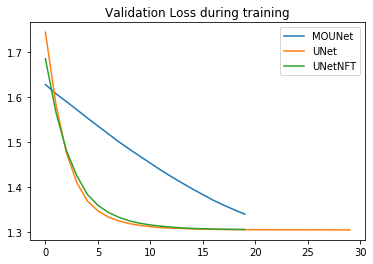

In [334]:
fig=plt.figure()
plt.plot(val_avg_losses6, label = 'MOUNet')
plt.plot(val_avg_losses4, label = 'UNet')
plt.plot(val_avg_losses3, label = 'UNetNFT')
plt.legend()
plt.title('Validation Loss during training')
plt.show()
fig.savefig('Plots/NITRC_right_left_valloss_'+str(train_ratio)+'_SP.jpg')

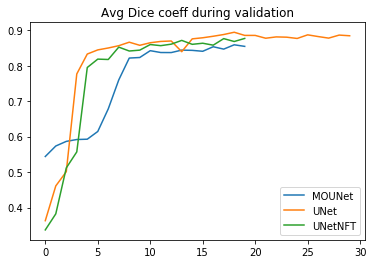

In [335]:
fig=plt.figure()
plt.plot(val_avg_dscoeffs6, label = 'MOUNet')
plt.plot(val_avg_dscoeffs4, label = 'UNet')
plt.plot(val_avg_dscoeffs3, label = 'UNetNFT')
plt.title('Avg Dice coeff during validation')
plt.legend()
plt.show()
fig.savefig('Plots/NITRC_right_left_valdice_'+str(train_ratio)+'_SP.jpg')

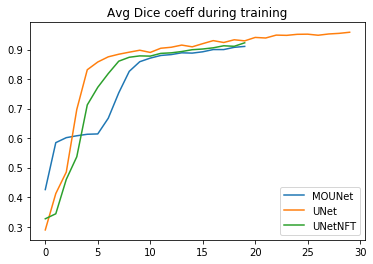

In [336]:
fig=plt.figure()
plt.plot(avg_dscoeffs6, label = 'MOUNet')
plt.plot(avg_dscoeffs4, label = 'UNet')
plt.plot(avg_dscoeffs3, label = 'UNetNFT')
plt.title('Avg Dice coeff during training')
plt.legend()
plt.show()
fig.savefig('Plots/NITRC_right_left_traindice'+str(train_ratio)+'_SP.jpg')

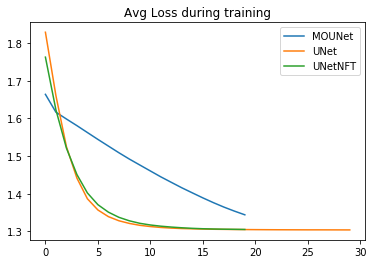

In [337]:
fig=plt.figure()
plt.plot(avg_losses6, label = 'MOUNet')
plt.plot(avg_losses4, label = 'UNet')
plt.plot(avg_losses3, label = 'UNetNFT')
plt.title('Avg Loss during training')
plt.legend()
plt.show()
fig.savefig('Plots/NITRC_right_left_trainloss'+str(train_ratio)+'_SP.jpg')